In [1]:
import warnings
warnings.filterwarnings("ignore")  # Ignore all warnings

import numpy as np
import matplotlib.pyplot as plt
from agentic_energy.milp.milp_mcp_server import records_to_arrays, solve_daily_milp
from agentic_energy.data_loader import EnergyDataLoader
from agentic_energy.schemas import BatteryParams, DayInputs, EnergyDataRecord, SolveFromRecordsRequest

2025-10-10 21:33:34.935 | DEBUG    | agentics.core.llm_connections:<module>:121 - AGENTICS is connecting to the following LLM API providers:
2025-10-10 21:33:34.935 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-10 21:33:34.935 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-10 21:33:34.944 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29 - No LLM provider specified. Using the first available provider.
2025-10-10 21:33:34.944 | DEBUG    | agentics.core.llm_connections:get_llm_provider:31 - Available LLM providers: ['gemini']. Using 'gemini'
2025-10-10 21:33:34.935 | DEBUG    | agentics.core.llm_connections:<module>:129 - 0 - Gemini
2025-10-10 21:33:34.935 | DEBUG    | agentics.core.llm_connections:<module>:135 - Please add API keys in .env file to add or disconnect providers.
2025-10-10 21:33:34.944 | DEBUG    | agentics.core.llm_connections:get_llm_provider:29

Forecast Engine using device: cpu


In [2]:
italy_obj = EnergyDataLoader(region="ITALY")
italy_data = italy_obj.load_region_data()

2025-10-10 21:33:36.648 | DEBUG    | agentics.core.agentics:from_csv:312 - Importing Agentics of type EnergyDataRecord from CSV /Users/millendroy/Projects/Agentic_Energy/Agentics_for_EnergyArbitrage_Battery/energy_arbitrage/agentic_energy/data/Italy_data.csv


In [3]:
italy_data[0]

EnergyDataRecord(timestamps='2022-01-01 00:00:00', prices=170.28, consumption=22.4, year=None, region='ITALY')

In [4]:
stats= await EnergyDataLoader.get_summary_stats_from_ag(italy_data)
print(stats.pretty_print())

Atype : <class 'agentic_energy.schemas.SummaryStats'>
region: ITALY
total_records: 17516
date_range:
  start: '2022-01-01 00:00:00'
  end: '2023-12-31 23:00:00'
prices:
  count: 17516
  min: 2.46
  max: 870.0
  avg: 215.61380052523407
  median: 175.01
  p25: 119.9175
  p75: 264.4875
  std: 131.54084577611607
  var: 17302.99410749595
consumption:
  count: 17516
  min: 17.49
  max: 49.93
  avg: 31.84034996574561
  median: 31.36
  p25: 26.1
  p75: 37.25
  std: 6.589954117466047
  var: 43.42749527030771




In [5]:
capacity = 1.0  # kWh
batterydetails = BatteryParams(
    capacity_kwh=capacity,   # 4-hour energy at 100 kW power: good for diurnal spreads
    soc_init=0.50,        # neutral start
    soc_min=0.0,         # keep 10% buffer for longevity + contingency
    soc_max=1.0,         # avoid top-of-charge stress
    cmax_kw=capacity/4,        # 4-hour duration (capacity/4)
    dmax_kw=capacity/4,        # symmetric charge/discharge
    eta_c=0.95,           # ~92% round-trip when paired with eta_d
    eta_d=0.95,
    soc_target=0.50       # keep headroom to buy when prices dip; adjust by time-of-day policy
)

In [6]:
# now have a for loop to run milp on each day
result = []
day_info =[]
decision_list = []
soc_list =[]
for i in range(len(italy_data)//24):
    print(f"Solving day {i+1} of {len(italy_data)//24}")
    records = SolveFromRecordsRequest(
        battery=batterydetails,
        records=italy_data[i*24:(i+1)*24],
        dt_hours=1.0,
        allow_export=True,
        solver = None,
        solver_opts = None
    )

    prices, demand = records_to_arrays(records.records)
    day = DayInputs(
        prices_buy=prices,
        demand_kw=demand,
        prices_sell=prices,
        allow_export=records.allow_export,
        dt_hours=records.dt_hours
    )
    day_info.append(day)
    res = solve_daily_milp(records.battery, day, records.solver, records.solver_opts)
    result.append(res)
    decision_list+=res.decision
    batterydetails.soc_init=res.soc[-1]
    soc_list+=res.soc[:-1]


Solving day 1 of 729
Set parameter WLSAccessID


[10/10/25 21:33:36] INFO     Set parameter WLSAccessID                                           ]8;id=632452;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=844466;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Set parameter WLSSecret


                    INFO     Set parameter WLSSecret                                             ]8;id=573859;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=988071;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Set parameter LicenseID to value 2718037


                    INFO     Set parameter LicenseID to value 2718037                            ]8;id=333304;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=715674;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\

Academic license 2718037 - for non-commercial use only - registered to mi___@columbia.edu


                    INFO     Academic license 2718037 - for non-commercial use only - registered ]8;id=723863;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py\gurobi_qpif.py]8;;\:]8;id=246377;file:///Users/millendroy/anaconda3/envs/agentics/lib/python3.11/site-packages/cvxpy/reductions/solvers/qp_solvers/gurobi_qpif.py#160\160]8;;\
                             to mi___@columbia.edu                                                                 

Solving day 2 of 729
Solving day 3 of 729
Solving day 4 of 729
Solving day 4 of 729
Solving day 5 of 729
Solving day 5 of 729
Solving day 6 of 729
Solving day 7 of 729
Solving day 8 of 729
Solving day 9 of 729
Solving day 6 of 729
Solving day 7 of 729
Solving day 8 of 729
Solving day 9 of 729
Solving day 10 of 729
Solving day 10 of 729
Solving day 11 of 729
Solving day 12 of 729
Solving day 13 of 729
Solving day 14 of 729
Solving day 11 of 729
Solving day 12 of 729
Solving day 13 of 729
Solving day 14 of 729
Solving day 15 of 729
Solving day 16 of 729
Solving day 17 of 729
Solving day 18 of 729
Solving day 19 of 729
Solving day 15 of 729
Solving day 16 of 729
Solving day 17 of 729
Solving day 18 of 729
Solving day 19 of 729
Solving day 20 of 729
Solving day 21 of 729
Solving day 22 of 729
Solving day 20 of 729
Solving day 21 of 729
Solving day 22 of 729
Solving day 23 of 729
Solving day 24 of 729
Solving day 25 of 729
Solving day 26 of 729
Solving day 27 of 729
Solving day 23 of 729
So

In [7]:
len(result)

729

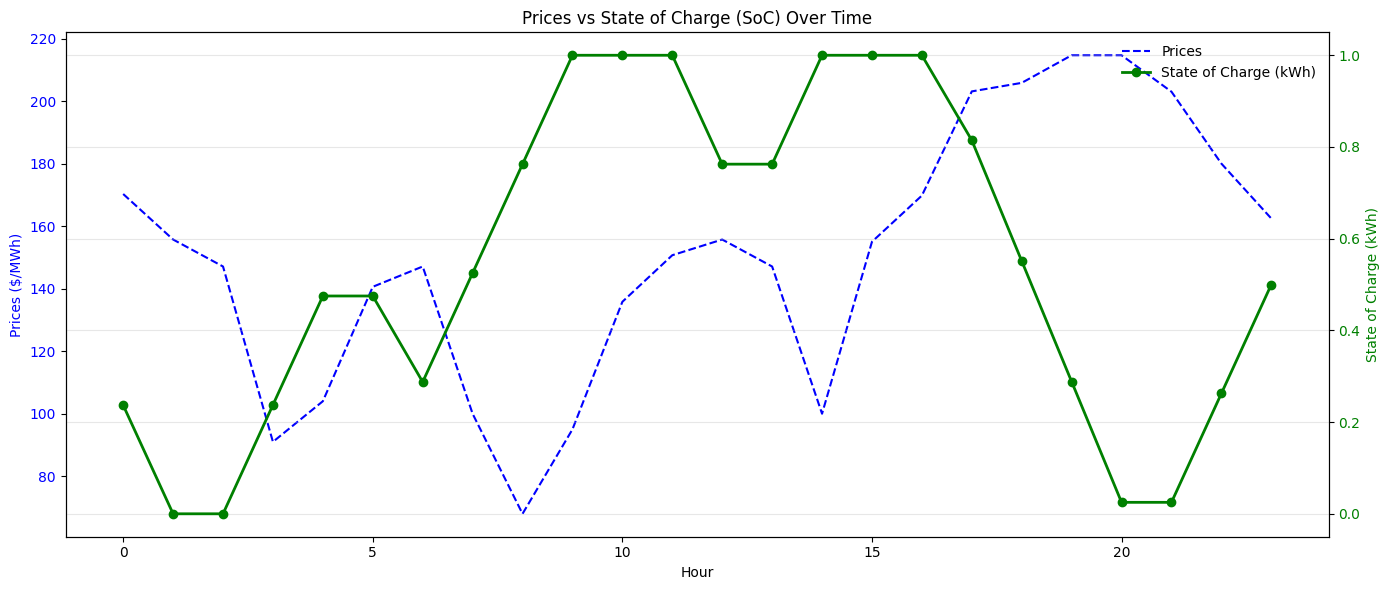

In [8]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)
fig, ax1 = plt.subplots(figsize=(14, 6))

# --- Primary axis (Prices) ---
ax1.plot(hours, day_info[0].prices_buy, '--b', label='Prices')
ax1.set_xlabel('Hour')
ax1.set_ylabel('Prices ($/MWh)', color='b')
ax1.tick_params(axis='y', labelcolor='b')

# --- Secondary axis (State of Charge) ---
ax2 = ax1.twinx()
ax2.plot(hours, np.array(result[0].soc[1:]) * batterydetails.capacity_kwh,
         '-og', label='State of Charge (kWh)', linewidth=2, markersize=6)
ax2.set_ylabel('State of Charge (kWh)', color='g')
ax2.tick_params(axis='y', labelcolor='g')


# --- Legends ---
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='best', frameon=False)

plt.title('Prices vs State of Charge (SoC) Over Time')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()


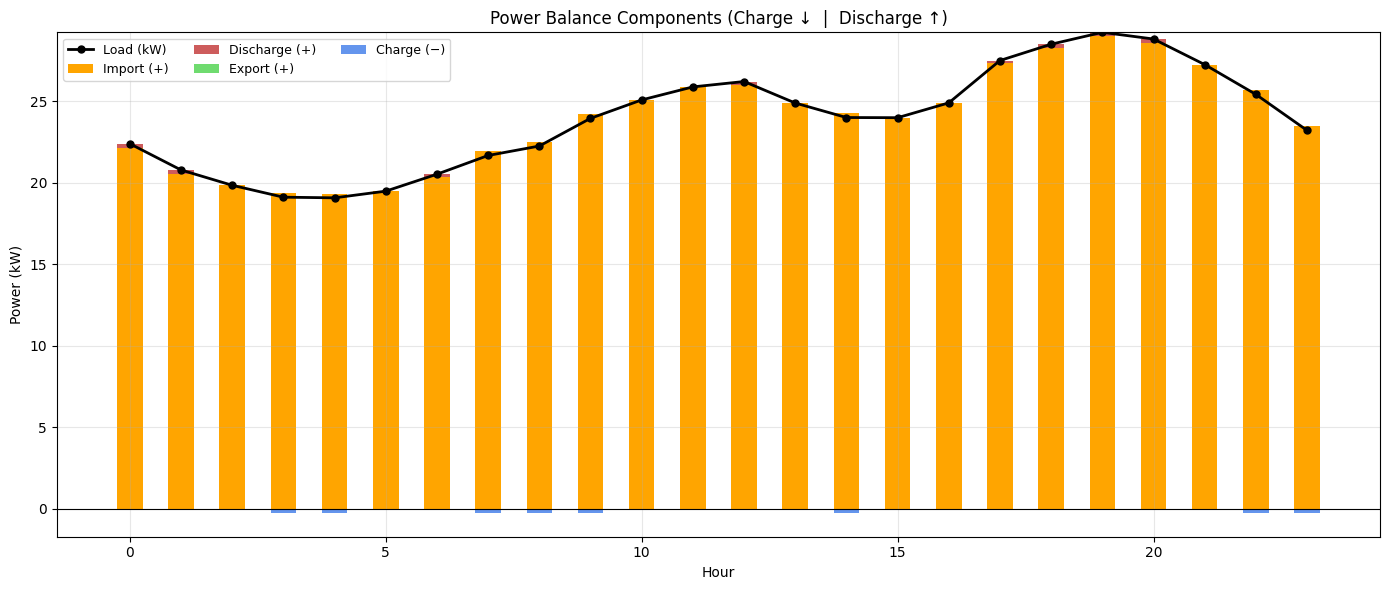

In [9]:
import numpy as np
import matplotlib.pyplot as plt

hours = np.arange(24)

# Data arrays
load = np.array(day_info[0].demand_kw)
charge = np.array(result[0].charge_kw)
discharge = np.array(result[0].discharge_kw)
import_kw = np.array(result[0].import_kw)
export_kw = np.array(result[0].export_kw) if getattr(day_info[0], "allow_export", False) else np.zeros_like(load)

# Flip battery convention for visualization
charge_vis = -charge       # show charge below 0
discharge_vis = discharge  # show discharge above 0

# ---------------------- PLOT ----------------------
fig, ax = plt.subplots(figsize=(14, 6))

# --- positive side stacking (Import + Discharge + Export) ---
# import is base layer
ax.bar(hours, import_kw, width=0.5, color='orange', label='Import (+)')
# discharge stacked on top of import
ax.bar(hours, discharge_vis, width=0.5, bottom=import_kw, color='indianred', label='Discharge (+)')
# export stacked on top (for clear separation)
ax.bar(hours, export_kw, width=0.5, bottom=import_kw + discharge_vis, color='limegreen', alpha=0.7, label='Export (+)')

# --- negative side stacking (Charge only) ---
ax.bar(hours, charge_vis, width=0.5, color='cornflowerblue', label='Charge (−)')

# --- Load as line ---
ax.plot(hours, load, '-ok', linewidth=2, markersize=5, label='Load (kW)')

# Formatting
ax.axhline(0, color='black', linewidth=0.8)
ax.set_ylabel("Power (kW)")
ax.set_xlabel("Hour")
ax.set_title("Power Balance Components (Charge ↓  |  Discharge ↑)")
ax.legend(ncol=3, loc='upper left', fontsize=9)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [10]:
total_objective_value = 0
for day_result in result:
    total_objective_value += day_result.objective_cost
print(f"Total Objective Value over all days: ${total_objective_value:.2f} for {len(result)} days")

Total Objective Value over all days: $124827194.30 for 729 days


In [11]:
profit = day_info[0].prices_buy*discharge - day_info[0].prices_buy*charge
print(profit.sum())

108.42060625000005


In [12]:
len(decision_list)

17496

In [13]:
import pandas as pd
italy_data = pd.read_csv("agentic_energy/data/ITALY_data.csv")
italy_data.head()

,timestamps,prices,consumption,fossil_generation,wind_generation,month
0,2022-01-01 00:00:00,170.28,22.40,11.05,6.81,winter
1,2022-01-01 01:00:00,155.72,20.79,10.36,6.36,winter
2,2022-01-01 02:00:00,147.09,19.85,9.60,6.12,winter
3,2022-01-01 03:00:00,91.00,19.12,9.16,5.94,winter
4,2022-01-01 04:00:00,104.00,19.08,8.43,6.02,winter


In [14]:
italy_data.shape

(17516, 6)

In [15]:
17496+24, 17496/24, len(soc_list)

(17520, 729.0, 17496)

In [16]:
italy_data=italy_data.iloc[:len(decision_list)]
soc_list = soc_list[:len(decision_list)]

In [17]:
# I want to fill the decisions column in such a way that if soc_t > soc_t-1 then decision = 1 (charging)
# if soc_t < soc_t-1 then decision = -1 (discharging)
# if soc_t == soc_t-1 then decision = 0 (idle)
italy_data["soc"] = soc_list
italy_data['soc_prev'] = italy_data['soc'].shift(1)
italy_data['decisions'] = 0  # Initialize with 0 (idle)
italy_data.loc[italy_data['soc'] > italy_data['soc_prev'], 'decisions'] = 1   # Charging
italy_data.loc[italy_data['soc'] < italy_data['soc_prev'], 'decisions'] = -1  # Discharging
italy_data.loc[italy_data['soc'] == italy_data['soc_prev'], 'decisions'] = 0   # Idle



In [18]:
italy_data.head()

,timestamps,prices,consumption,fossil_generation,wind_generation,month,soc,soc_prev,decisions
0,2022-01-01 00:00:00,170.28,22.40,11.05,6.81,winter,0.500000,NaN,0
1,2022-01-01 01:00:00,155.72,20.79,10.36,6.36,winter,0.236842,0.500000,-1
2,2022-01-01 02:00:00,147.09,19.85,9.60,6.12,winter,0.000000,0.236842,-1
3,2022-01-01 03:00:00,91.00,19.12,9.16,5.94,winter,0.000000,0.000000,0
4,2022-01-01 04:00:00,104.00,19.08,8.43,6.02,winter,0.237500,0.000000,1


In [19]:
italy_data.to_csv("agentic_energy/data/ITALY_data_with_decisions.csv", index=False)